# High-NA vectorial PSF generation

Detailed models are required to generate high-NA point-spread-functions. Due to the large angles, it is crucial to take into account the vectorial nature of the electric field. This approach allows for accurate modeling of polarization and the inclusion of various correction factors.

For more information, please check https://arxiv.org/abs/2502.03170.

In [1]:
import jax

jax.config.update("jax_platform_name", "cpu")

import jax.numpy as jnp
import matplotlib.pyplot as plt

import chromatix.functional as cf

%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

# Equivalence between FF lens and High NA FF lens

We first show how to interchangeably use High NA FF lens in replacement of FF lens for low NA systems.

In [2]:
pupil_shape: tuple[int, int] = (256, 256)
f: float = 1e3
NA: float = 0.2
n: float = 1.5
wavelength: float = 0.532
wavelength_ratio: float = 1.0

padding_factor = 10
waist = f * NA / n * 3
dx = 2 * f * NA / n / min(pupil_shape) * padding_factor

In [3]:
field_pup0 = cf.gaussian_plane_wave(
    pupil_shape,
    dx,
    wavelength,
    wavelength_ratio,
    waist=waist,
    pupil=lambda field: cf.circular_pupil(field, 2 * f * NA / n),
)

field_ff_lens = cf.ff_lens(field_pup0, f, n, NA)
field_high_na = cf.high_na_ff_lens(
    field_pup0, f, n, NA, s_z_correction=False, apodization=False
)

psf_ff_lens = jnp.abs(field_ff_lens.u.squeeze()) ** 2
psf_high_na = jnp.abs(field_high_na.u.squeeze()) ** 2

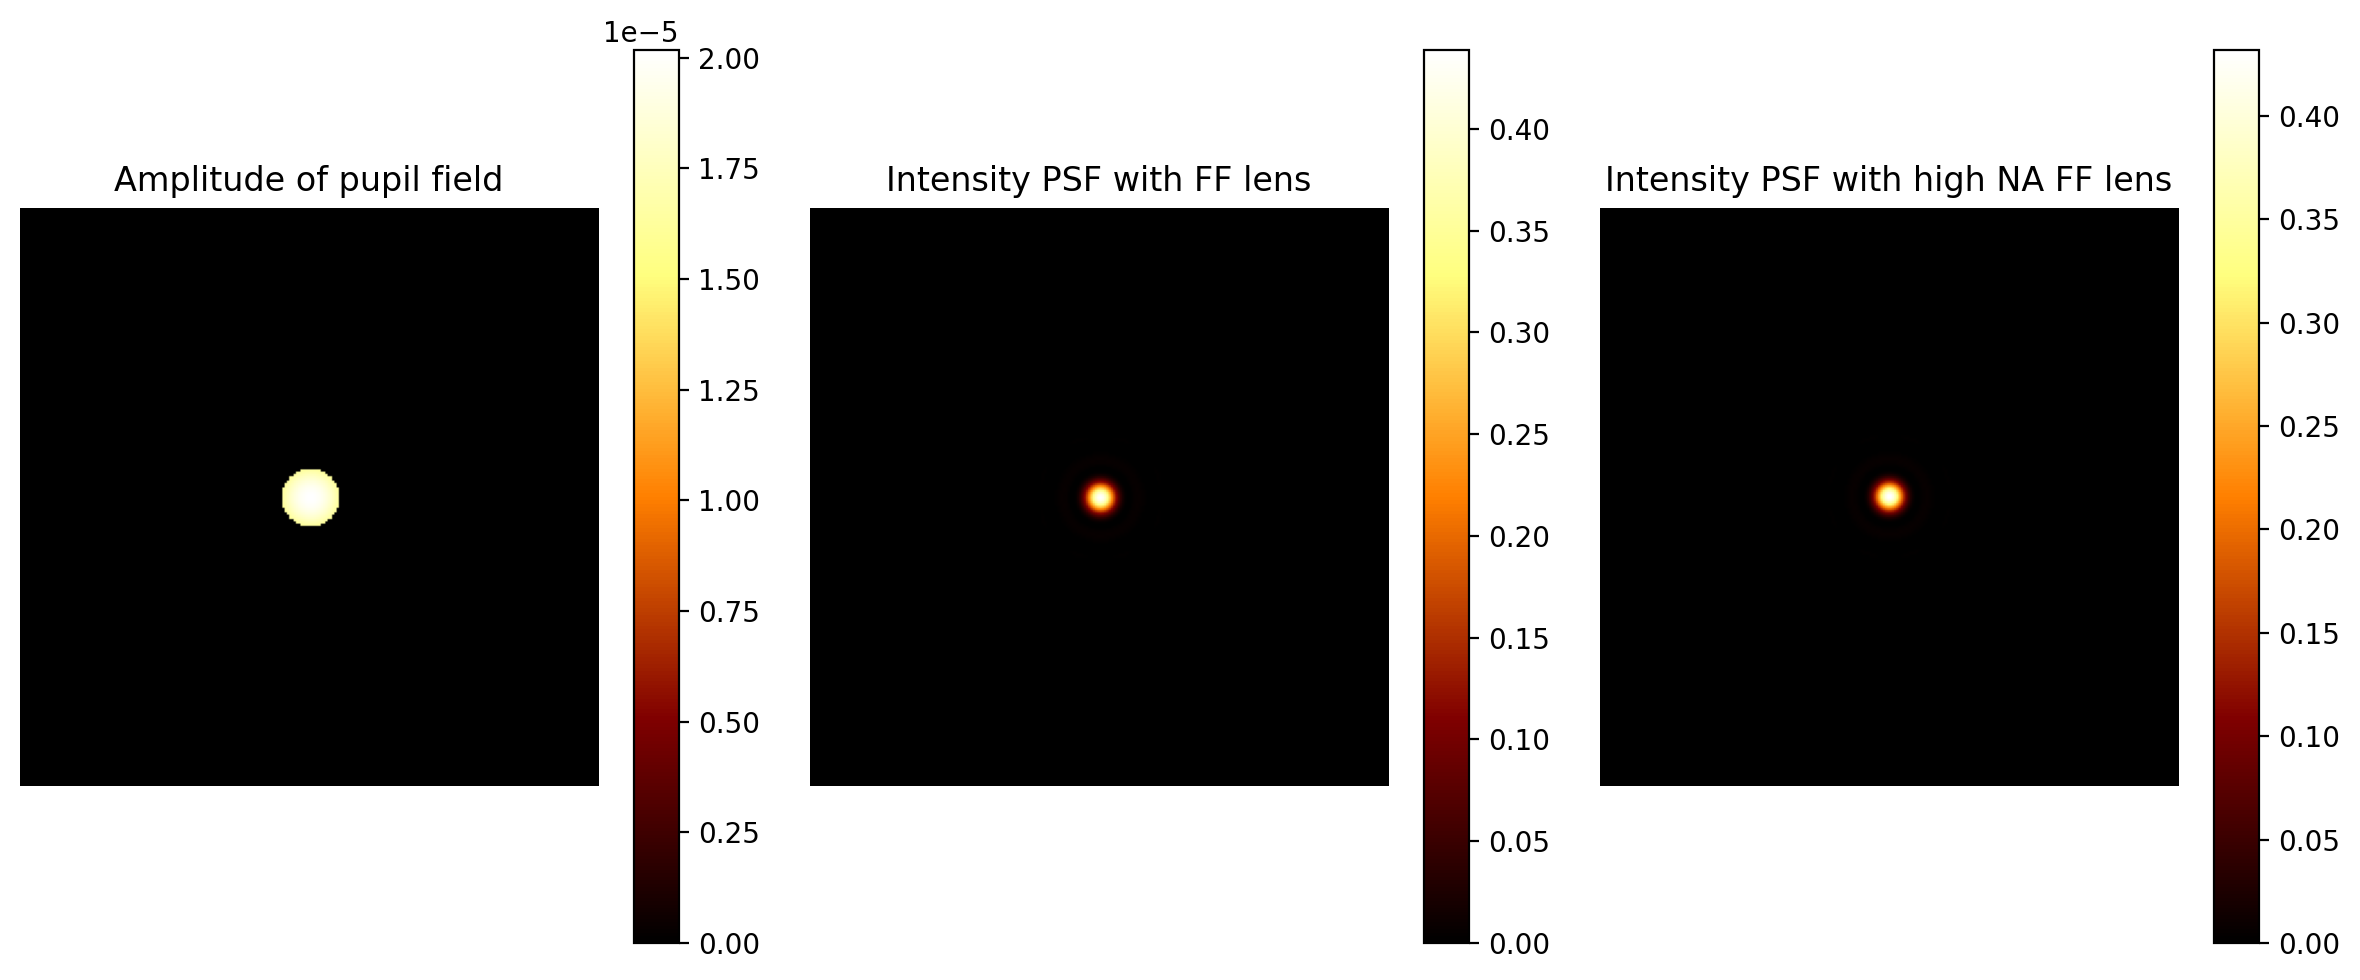

In [4]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(jnp.abs(field_pup0.u.squeeze()) ** 2, cmap="afmhot")
plt.title("Amplitude of pupil field")
plt.axis("off")
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(psf_ff_lens, cmap="afmhot")
plt.title("Intensity PSF with FF lens")
plt.axis("off")
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(psf_high_na, cmap="afmhot")
plt.title("Intensity PSF with high NA FF lens")
plt.axis("off")
plt.colorbar()
plt.tight_layout()
plt.show()

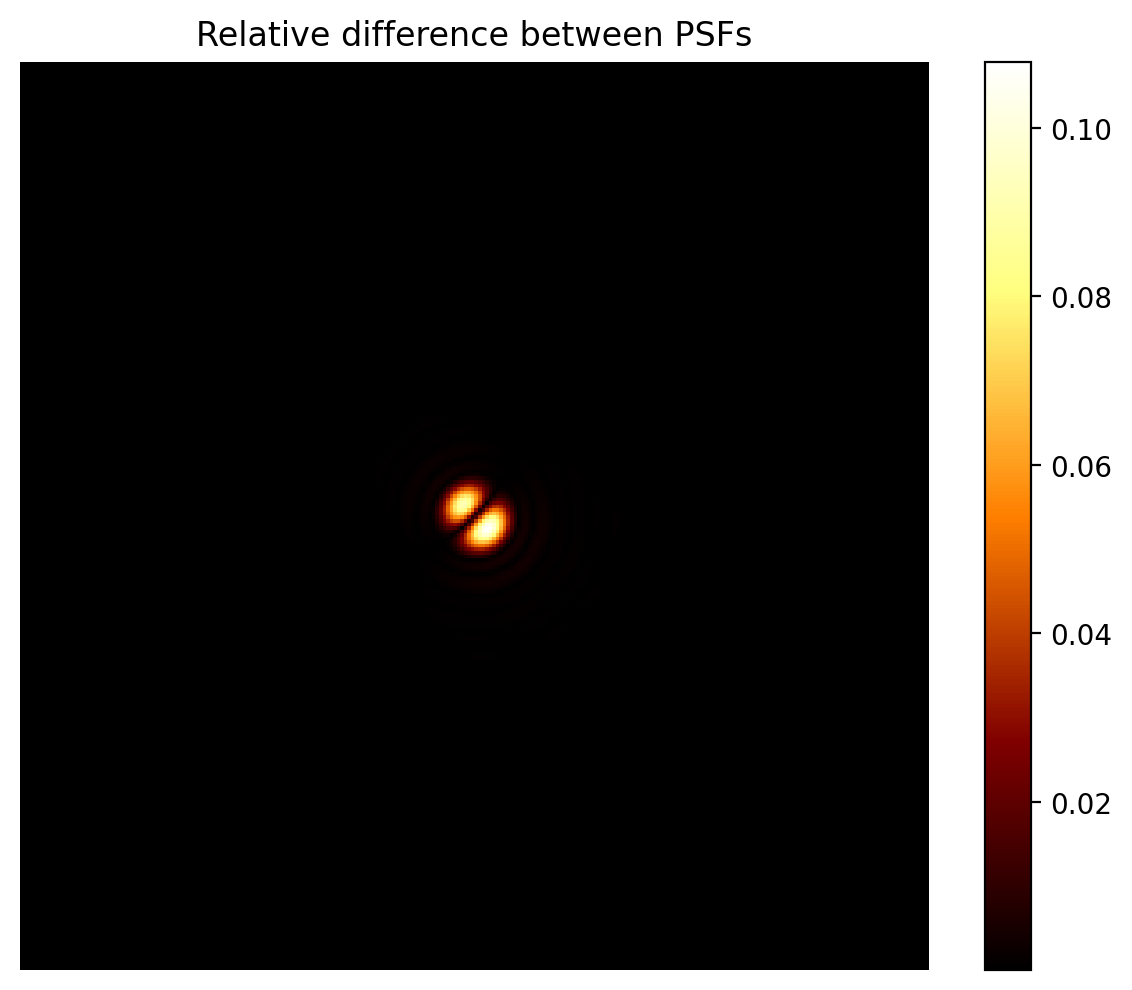

In [5]:
# display difference
plt.figure(figsize=(6, 5))
plt.imshow(jnp.abs(psf_high_na - psf_ff_lens) / jnp.max(psf_ff_lens), cmap="afmhot")
plt.title("Relative difference between PSFs")
plt.axis("off")
plt.colorbar()
plt.tight_layout()
plt.show()

# Zooming in with arbitrary shapes

The High NA FF lens allows arbitrary input/output pixel sizes and shapes. This allows more flexible choices, so that the pupil field fills the entire field-of-view and we zoom in as we do the FFT to the PSF region. The vanilla FF lens function uses the traditional FFT which will yield very small PSFs.

In [6]:
# Same parameters as before but no padding
dx = 2 * f * NA / n / min(pupil_shape)
# Output pixel size
camera_pixel_pitch = wavelength / NA / 2 / 30
output_shape = (128, 256)

field_pup = cf.gaussian_plane_wave(
    pupil_shape,
    dx,
    wavelength,
    wavelength_ratio,
    waist=waist,
    pupil=lambda field: cf.circular_pupil(field, 2 * f * NA / n),
)

field_ff_lens = cf.ff_lens(field_pup, f, n, NA)
field_high_na = cf.high_na_ff_lens(
    field_pup,
    f,
    n,
    NA,
    output_dx=camera_pixel_pitch,
    output_shape=output_shape,
    s_z_correction=False,
    apodization=False,
)

psf_ff_lens = jnp.abs(field_ff_lens.u.squeeze()) ** 2
psf_high_na = jnp.abs(field_high_na.u.squeeze()) ** 2

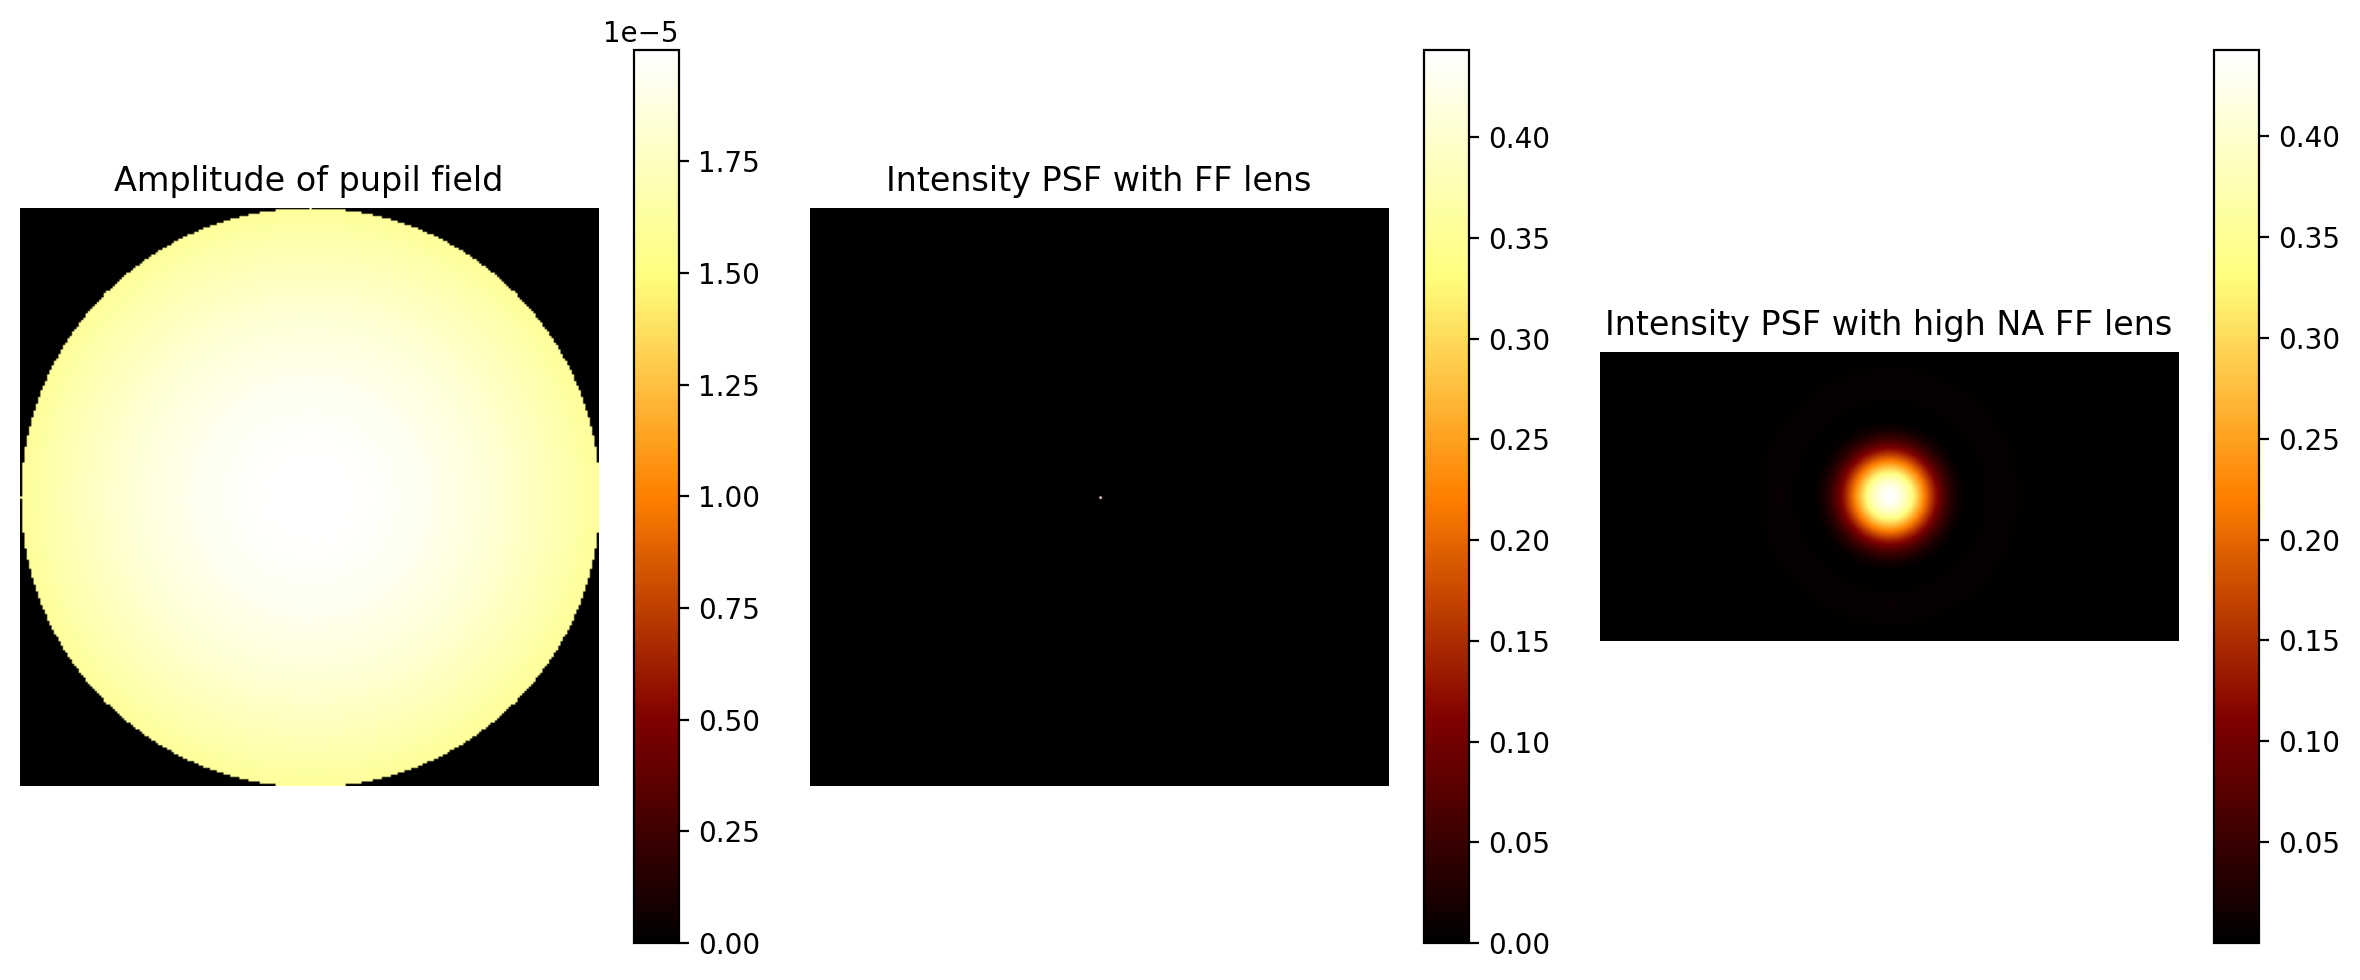

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(jnp.abs(field_pup.u.squeeze()) ** 2, cmap="afmhot")
plt.title("Amplitude of pupil field")
plt.axis("off")
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(psf_ff_lens, cmap="afmhot")
plt.title("Intensity PSF with FF lens")
plt.axis("off")
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(psf_high_na, cmap="afmhot")
plt.title("Intensity PSF with high NA FF lens")
plt.axis("off")
plt.colorbar()
plt.tight_layout()
plt.show()

# High-NA PSFs, scalar and vectorial cases

In the high-NA case, additional correction factors are introduced to account for the non-paraxial case. Additionally, the vectorial case accounts for polarization effects. 

In [8]:
NA: float = 1.2
waist = f * NA / n * 3
dx = 2 * f * NA / n / min(pupil_shape)
camera_pixel_pitch = wavelength / NA / 2 / 30

field_pup = cf.gaussian_plane_wave(
    pupil_shape,
    dx,
    wavelength,
    wavelength_ratio,
    waist=waist,
    pupil=lambda field: cf.circular_pupil(field, 2 * f * NA / n),
)
field_pup_vec = cf.gaussian_plane_wave(
    pupil_shape,
    dx,
    wavelength,
    wavelength_ratio,
    waist=waist,
    pupil=lambda field: cf.circular_pupil(field, 2 * f * NA / n),
    amplitude=jnp.array([0.0, 0.0, 1.0]),
    scalar=False,
)
field_scalar = cf.high_na_ff_lens(
    field_pup,
    f,
    n,
    NA,
    output_dx=camera_pixel_pitch,
    s_z_correction=True,
    apodization=True,
)
field_vec = cf.high_na_ff_lens(
    field_pup_vec,
    f,
    n,
    NA,
    output_dx=camera_pixel_pitch,
    s_z_correction=True,
    apodization=True,
)

psf_scalar = jnp.abs(field_scalar.u.squeeze()) ** 2
psf_vec = jnp.abs(field_vec.u.squeeze()) ** 2

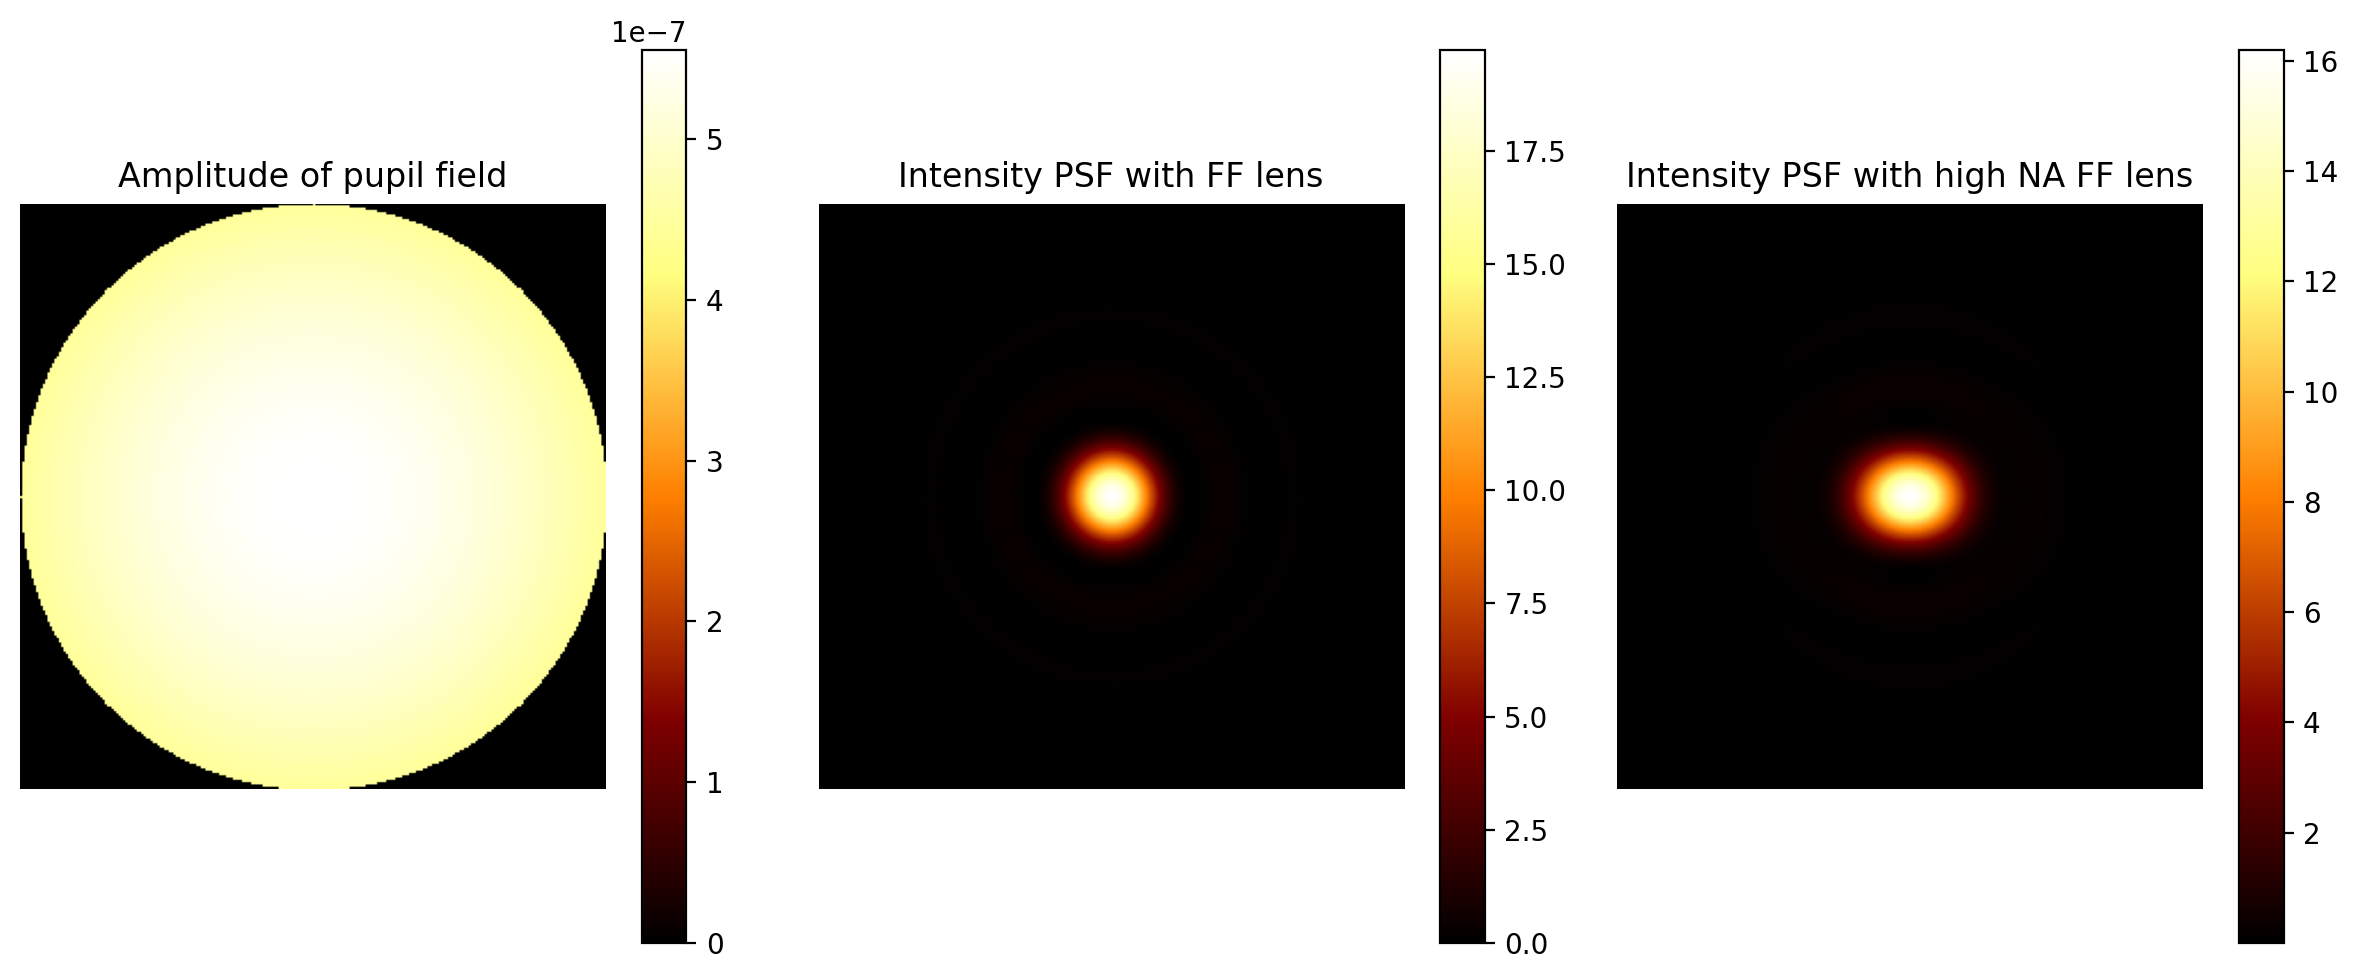

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(jnp.abs(field_pup.u.squeeze()) ** 2, cmap="afmhot")
plt.title("Amplitude of pupil field")
plt.axis("off")
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(psf_scalar, cmap="afmhot")
plt.title("Intensity PSF with FF lens")
plt.axis("off")
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(jnp.sum(psf_vec, axis=-1), cmap="afmhot")
plt.title("Intensity PSF with high NA FF lens")
plt.axis("off")
plt.colorbar()
plt.tight_layout()
plt.show()

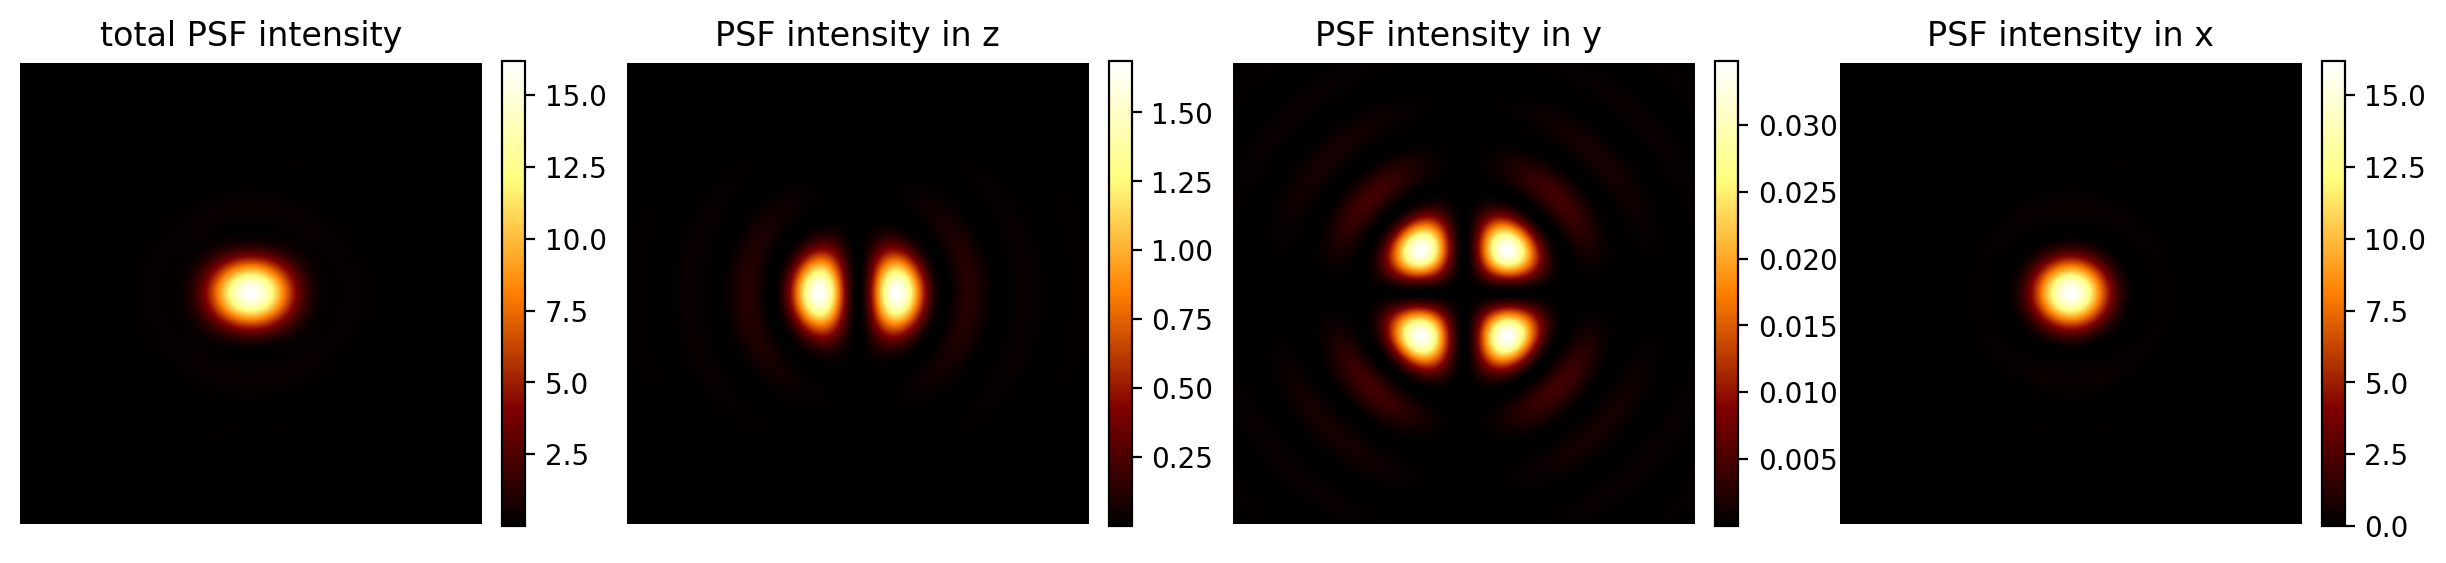

In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(141)
plt.imshow(jnp.sum(psf_vec.squeeze(), axis=-1), cmap="afmhot")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("total PSF intensity")
plt.axis("off")

plt.subplot(142)
plt.imshow(psf_vec.squeeze()[..., 0], cmap="afmhot")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("PSF intensity in z")
plt.axis("off")

plt.subplot(143)
plt.imshow(psf_vec.squeeze()[..., 1], cmap="afmhot")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("PSF intensity in y ")
plt.axis("off")

plt.subplot(144)
plt.imshow(psf_vec.squeeze()[..., 2], cmap="afmhot")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("PSF intensity in x")
plt.axis("off")

plt.show()

# Energy conservation test

In [11]:
def compute_field_energy(field):
    return (jnp.sum(jnp.abs(field.u) ** 2) * field.dx**2).squeeze()


print("Pupil pixel sizes:", field_pup.dx.squeeze())
print("Total energy pupil:", compute_field_energy(field_pup))
print("Field pixel sizes", field_scalar.dx.squeeze())
print("Total energy ff lens", compute_field_energy(field_scalar))

Pupil pixel sizes: [6.25 6.25]
Total energy pupil: [1.0000002 1.0000002]
Field pixel sizes [0.00738889 0.00738889]
Total energy ff lens [1.1567962 1.1567962]
